In [49]:
import os
import sys
from pathlib import Path

ASL = os.path.join(str(Path.home()), "ASL")
src = os.path.join(str(Path.home()), "ASL", "src")
os.chdir( ASL )
sys.path.append(ASL)
sys.path.append(src)

# STD
import os
import copy

# MISC
import numpy as np
import torch
import imageio
import cv2
from PIL import Image

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.patches as patches
import pickle
from PIL import Image, ImageDraw
import skimage
from skimage import measure
from skimage.segmentation import mark_boundaries, find_boundaries

from visu.colors import *
from visu.flow_viz import *

In [52]:
reference_100 = np.array( [0.785, 0.891,0.652,0.885] )

val_res_paths = [
                "/home/jonfrey/Results/scannet_cl_buffer_filling/2021-07-19T10:36:55_random",
                "/home/jonfrey/Results/scannet_cl_buffer_filling/2021-07-19T10:36:55_cover_sequence",
                "/home/jonfrey/Results/scannet_cl_buffer_filling/2021-07-18T23:41:53_loss_equal"
                ]
labels = ["Random","Cover-Sequence","Label-Statistics"]

val_res_paths = [s+"/val_res.pkl" for s in val_res_paths]

def mat_from_pkl(a):
    with open(a, "rb") as input_file:
        data = pickle.load(input_file)
    res= np.unique( np.array( data[-1] ), return_index =True) 
    idx = res[1]
    mat = np.zeros( (idx.shape[0], idx.shape[0]))
    data = [np.array(d) for d in data]

    el = data[-1].max()+1
    for i in range( el ):
        for j in range( el  ):
            mat[i,j] = data[j][data[-1] == i][-1]
    return mat


def get_metrics( val_res_path,start=0 ):
    mat = mat_from_pkl(val_res_path)
    mat[start:,start:]
    elements = np.ones_like(mat)
    FWT = np.triu(mat, k =1).sum()  / np.triu(elements, k =1).sum() 
    dia = np.diagonal(mat)
    mat_out = np.copy(mat)
    for i in range(mat.shape[1]):
        mat_out[:,i] -= dia[i]
    BWT = np.tril(mat_out, k =-1).sum() / np.tril(elements, k =-1).sum() 
    ACC = np.tril(mat, k =0).sum()  / np.tril(elements, k =0).sum()
    
    return { "ACC": ACC,
     "FWT":FWT,
     "BWT":BWT,
    "Omega": np.mean( mat[-1,1:]/reference_100 )
    }

metrices = [ get_metrics(v, start=1) for v in val_res_paths ]
FWT = [ a["FWT"] for a in metrices ]
BWT = [ a["BWT"] for a in metrices ]
ACC = [ a["ACC"] for a in metrices ]
Omega = [ a["Omega"] for a in metrices ]

metrics = {"ACC": ACC, "FWT": FWT, "BWT": BWT, "Omega": Omega}
metrics["Omega"]

FWT 

[0.5232404083013534, 0.5168896555900574, 0.5199258208274842]

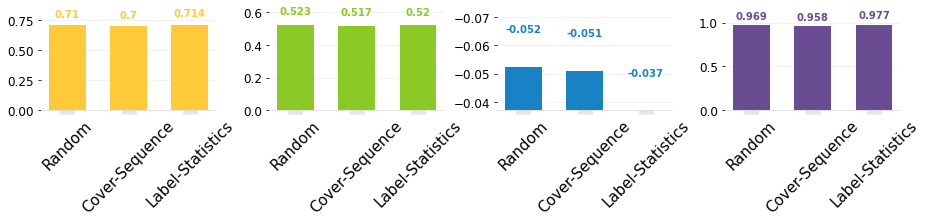

In [53]:
textwidth = 12.7 #cm
fig, ax = plt.subplots(1, 4, figsize=(textwidth, 2.6), sharex=False, sharey=False)
left  = 0.05  # the left side of the subplots of the figure
right = 0.99    # the right side of the subplots of the figure
bottom = 0.35   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.2  # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

#plt.setp(ax, yticks=[1, 2, 3])

for i,key in enumerate( metrics.keys()):
    
    bars = ax[i].bar(labels, metrics[key], facecolor=COL_MAP(i+1),width =0.6)
    #ax[i].set_xlabel(key,fontsize=20, fontname= 'Liberation Serif' )
    # ax[i].set_title(key,fontsize=20, fontname= 'Liberation Serif' )
    #ax[i].set_ylabel(key,fontsize=15, fontname= 'Liberation Serif')
    ax[i].grid(True)
    ax[i].tick_params(axis="x", labelsize=15,rotation=45,width =15,color=(181/255, 181/255, 181/255, 0.36))
    ax[i].tick_params(axis="y", labelsize=12)

    # Axis formatting.
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_color('#DDDDDD')
    
    ax[i].yaxis.grid(True, color='#EEEEEE')
    ax[i].xaxis.grid(False)
    #ax[i].tick_params(bottom=False, left=False)
    ax[i].set_axisbelow(True)
    # Add text annotations to the top of the bars.

    j = 1
    
    if  metrics[key][j] > 0:
        ax[i].set_ylim(0,  max( metrics[key])*1.2  )
    else:
        ax[i].set_ylim(min( metrics[key])*1.4, max( metrics[key])*1  )
        
        
    bar_color = bars[0].get_facecolor()
    if metrics[key][j] < 0:
        ax[i].invert_yaxis()
    for j,bar in enumerate(bars):
      h = [ bar.get_height() for bar in bars]
      
      if  metrics[key][j] > 0: 
        bh = bar.get_height() + 0.05
        va = "bottom"
      else:
        bh = bar.get_height() - 0.015
        va = "top"
      ax[i].text(
          bar.get_x() + bar.get_width() / 2,
          bh ,
          round( metrics[key][j]  , 3),ha="center", va=va,
                color=bar_color,
      weight='bold'
      )


plt.show()
from visu.visualizer import get_img_from_fig
res = get_img_from_fig(fig, dpi=360)
imageio.imwrite( 'docs/bar_plot_filling.png', res)
# plt.close()